In [1]:
import bvhsdk
import ik
import mathutils
import skeletonmap
import surface
import plotanimation
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

# Motion Capture Retargeting: Preserving Surface Spatial Relationship

## Introduction
Toy Story was released in 1995 as the first full length film produced entirely through computer animation techniques (cite Henne). Besides Pixar's production, several applications employ digital animations to entertain, convey information, educate, among others. Some exploits the use of virtual human models to make the human-computer interatction more natural and accessible. Talita, the virtual human of the TAS project (cite De Martino), is a signing avatar that communicates with deaf students using the Brazilian Sign Language. The goal of the TAS project is to help the deaf and hard of hearing to access information and in their educational process.

Humans uses not only the voice and facial expression cues to understand intentions, motives and wills, but also the movements of our body and limbs may carry semantic information on the emotion that one is triyng to express. The location, orientation and speed of the hand are some of the parameters that characterizes a sign language gesture, slightly discrepancies will express different messages or even make the gesture unrecognizable. Therefore, an accurate motion representation by the virtual agent should be of great concern.

Keyframing is a technique to animate an avatar, the animator adjusts crucial poses of the 3D character on dispersed frames and an algorithm fills the gap between two poses by interpolating them over time, which creates the impression of the desired motion. Another digital animation technique is Motion Capture (MoCap) that aims to lessen the time-consuming and tedious work of keyframing animations. MoCap systems registers an actor performing the desired motion to animate a 3D character. Optical Motion Capture systems, for example, uses a set of cameras to track the position over time of reflective markers placed on the body surface of the performer. The motion is then transferred to the avatar, the motion retargeting process, without the need to create all the poses along the action.

The motion retargeting, however, can cause ill-conditioned poses when the body proportions of the performer and the avatar are different. The motion retargeting of an actor with long arms covering his ears, as an example, to a 3D character with short arms results in a unrecognizable action, since the hands of the avatar will not reach its ears. In this case, the animator must inspect the animation, identify the irregular artifacts and correct them with keyframing, adjusting the avatar pose to the desired one. Some motion retargeting algorithms aims to avoid such artifacts to further reduce the inspection and adjustments needed by the animator.

Furtheremore, the standard approach to animate 3D characters is the skeleton animation. The skeleton, a hierarchical structure of joints and bones, stores the actual motion data and the surface of the character is deformed accordingly to the rotation and translation of the skeleton. Often MoCap systems, game engines, 3D modeling and animation software built the skeleton with different specifications(cite Kitagawa), i.e., distinct topologies of the hierarchical structure. This complicates the motion retargeting process because the joints and bones of one skeleton may not exist in another or be represented in another way.



## Related Works

(em construção)

## Workflow
<img src="../figures/Workflow3.svg" alt="drawing" width="600"/>

## Initial Retargeting

### Skeleton Animation
This chapter describes the Initial Motion Retargeting process, which receives the source animation and the target skeleton as inputs, both BVH files. The output is an animation of the target skeleton performing the movements of the source skeleton that can be exported as a BVH file. The success of the process does not depend on matching topologies of the skeletons, but the first pose of the source animation and the target skeleton pose must be as close as possible to the T-Pose. The output of the Initial Retargeting is the target skeleton animation. The target animation does not exploit yet the “surface-awareness” adjustments that the methods described in the subsequent sections provide, but it can already be imported in game engines or animation softwares to animate a 3D character.


To animate a skeleton, its joints must rotate and translate along the frames, conveying the impression of motion. The hierarchical representation of the skeleton allows an all-around description of the motion by only preserving the rotational and translational values of a joint regarding its parent joint, i.e., local rotations and translations. The local transform matrix $M$ is the combination of both rotation $R$ and translation matrix $T$:

\begin{equation}
\label{eq:transformmatrix}
M = TR = \begin{bmatrix}
    R_{3x3} & T \\
    0 & 1
    \end{bmatrix}
\end{equation}

Given a joint $n$ in the skeleton, its global transform matrix $M_{global}^{n}$ is the combination of the local transform matrices of all the joints above the hierarchy. The position of the joint is computed through the global transform matrix.

\begin{equation}
\label{eq:transformmatrixglobal}
M_{global}^{n} = \prod_{i=0}^{n} M_{local}^{i}
\end{equation}

\begin{equation}
\label{eq:position}
\mathbf{p}_{n} = M_{global}^{n}[0,0,0,1]^T
\end{equation}

In [2]:
sourceAnimationPath = '..\data\source_animation-entender.bvh'
sourceAnimation = bvhsdk.ReadFile(sourceAnimationPath)

In [6]:
%matplotlib qt

def PlotBVH(animation):           
    def update(frame, scatters, lines):
        for scat, joint in zip(scatters,animation.getlistofjoints()):
            position = joint.getPosition(frame)
            scat.set_data([position[0]],[position[1]])
            scat.set_3d_properties([position[2]])
        
        for line, bone in zip(lines, animation.getBones(frame)):
            line.set_data([bone[0], bone[3]], [bone[1], bone[4]])
            line.set_3d_properties([bone[2], bone[5]])
        return scatters+lines

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    scatters = []
    maxdata = -np.inf
    mindata = np.inf
    for joint in animation.getlistofjoints():
        position = joint.getPosition(frame = 0)
        scatters.append(ax.plot([position[0]],[position[1]],[position[2]],'o', color='red', markersize=1)[0])
        if np.min(position)<mindata:
            mindata = np.min(position)
        if np.max(position)>maxdata:
            maxdata = np.max(position)
            
    lines = []
    for bone in animation.getBones(0):
        lines.append(ax.plot([bone[0], bone[3]], [bone[1], bone[4]], [bone[2], bone[5]],'-o', color='black')[0])
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim(mindata,maxdata)
    ax.set_ylim(mindata,maxdata)
    ax.set_zlim(mindata,maxdata)
    ani = FuncAnimation(fig, update, frames=np.arange(animation.frames), fargs=(scatters,lines) ,interval=1, blit=True)
    return ani

#bla = BLA(sourceAnimation)
_ = PlotBVH(sourceAnimation)

### Skeleton Mapping

Figure 2 presents two approaches to represent a virtual human skeleton. Although both can animate a humanoid-shaped model, transferring motions between the skeletons is not straightforward. A correspondence between joints of the skeletons is mandatory to identify which joints from the target skeleton should mimic the motion from the source skeleton. It is possible to infer a correspondence using the joints’ name automatically, but note that they may not be placed at the same point in the respective skeleton, as the shoulders in the figure. Therefore, the user can provide a correspondence between skeletons to properly map joints and to perform the motion retargeting (Detailed in Appendix A) (cite Monzani and Hsieh).

<img src="../figures/skelmap.png" alt="drawing" width="800"/>

In this work, it is required that both target and source skeletons have at least the set of joints: one hips joint, three spine joints, neck and head joints, and right and left joints for the shoulders, elbows, wrists, femurs, knees and feet. The joints referenced will be the only ones used in the Initial Retargeting proccess.

### Bones Alignment

Bones Alignment enforces that the vector of a mapped joint from the target skeleton pointing towards its child joint has the same direction of the correspondent vector from the source skeleton. Then, for every frame, we apply the same transform from the source skeleton joint to the correspondent target joint.

The rotation matrix $R_{A}$ to align the bone vector of the target skeleton onto the bone vector of the source skeleton is calculated and applied to the global rotation of the target skeleton joint $R_{NG}^{n}$:

\begin{equation}
        \label{eq:newglobal}
        R_{NG}^{n} = R_{A} R_{G}^{n}
        \end{equation}
        
Then, as expected by the BVH file format, we recover the local rotation of the joint $R_{L}^{n}$, the new global orientation is multiplied by its parent inverse rotation matrix.

\begin{equation}
        \label{eq:newglobal2}
        R_{NG}^{n} = \left(\prod_{i=0}^{n-1} R_{L}^{i}\right) R_{L}^{n} 
        \end{equation}

\begin{equation}
    \label{eq:newglobal3}
    R_{NG}^{n} = R_{G}^{n-1} R_{L}^{n}
    \end{equation}
        
\begin{equation}
    \label{eq:newglobal4}
    R_{L}^{n} = (R_{G}^{n-1})^{-1} R_{NG}^{n}
    \end{equation}
    
In the following frames, the rotation of a joint in the source animation, from the last frame to the current one, replaces the rotation $R_{A}$ to align the correspondent joint in the target skeleton.

The source motion of the root joint is decomposed into vertical and horizontal movement that are analyzed separately. The horizontal movement is the projection of the root joint position into the ground, the reason of the decomposition is the use of this projected point as a reference point for the feet (Section Surface Characterization).

The ratio is given by:

\begin{equation}
    \label{eq:heightratio}
    ratio = \frac{h_{root}^{tgt}}{h_{root}^{src}}
    \end{equation}
    
where $h_{root}^{tgt}$ and $h_{root}^{src}$ are the heights of the root joint of the target and source skeletons in the first frame. The horizontal and vertical movement of the root, $g(t)$ and $h(t)$ is computed. The translation of the root joint regarding the system origin is equal to these values recombined.

\begin{equation}
    \label{eq:rootmov}
    \mathbf{g}(t)_{root}^{src} = \mathbf{g}(t)_{root}^{tgt} ratio \hspace{10pt} and \hspace{10pt}
    \mathbf{h}(t)_{root}^{src} = \mathbf{h}(t)_{root}^{tgt} ratio
    \end{equation}

In [82]:
#TODO: RESULTADO

## Surface Characterization

### Surface Calibration

Molla defined a set of points to characterize the surface of the 3D model’s and performer’s body, the yellow dots on Figure 5.1.  The points are connected throughtriangles to create a mesh that represents the body surface. The points on the surfaceof the character and the performer need to be collected as close to the relative positionas possible, since the triangle mesh differences between the characters must represent differences of the characters’ surface, thus sampling surface points from different placesintroduces noise to the analysis. The thickness of the limbs are also registered and later they are represented by capsules to avoid self-penetration in the animation.

<img src="../figures/TalitaPoints.png" alt="drawing" width="800"/>

The user can obtain the surface points and radius of each limb of the character during its creation or through a 3D modeling software. To avoid a different unit measurement between the third part software and the animation, the user also stores the position of the root joint for comparison with the T-Pose BVH file.


In [3]:
#Load Source Surface
sourceSurfacePath = '..\data\surface_rodolfo.txt'
sourceSurface = surface.GetMoCapSurfaceFromTXT(sourceSurfacePath, highpolymesh = False)
#Load Target Skeleton and Surface
targetSkeleton = '..\\data\\target_skeleton.bvh'
targetAnimation = bvhsdk.ReadFile(targetSkeleton)
targetSurfacePath = '..\\data\\target_surface.csv'
targetSurface = surface.GetAvatarSurfaceFromCSV(targetSurfacePath, targetAnimation, False)

The mapping was successful


### Surface Motion Estimation


In [51]:
%matplotlib qt

def PlotBVHSurface(animation, surface):
    
    def update(frame, surf, lines, vertices, bones):
        for triangle_plot, triangle in zip(surf, range(len(surf))):
            triangle_plot.set_data(vertices[frame,triangle,:,0],vertices[frame,triangle,:,1])
            triangle_plot.set_3d_properties(vertices[frame,triangle,:,2])
        
        for line, bone in zip(lines, range(len(lines))):
            line.set_data([bones[frame,bone,0], bones[frame,bone,3]], [bones[frame,bone,1], bones[frame,bone,4]])
            line.set_3d_properties([bones[frame,bone,2], bones[frame,bone,5]])
        return surf+lines

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')

    print('Preparing plot:')
    print('Computing Surface...')
    #Draw Surface Mesh ###############################################
    vertices = [] #vertices[frame, triangle, edge, xyz]
    for frame in range(animation.frames):
        vertices_oneframe = []
        for triangle in surface.headmesh + surface.bodymesh:
            edge_0 = triangle[0].getPosition(animation,frame)
            edge_1 = triangle[1].getPosition(animation,frame)
            edge_2 = triangle[2].getPosition(animation,frame)
            vertices_oneframe.append([edge_0, edge_1, edge_2, edge_0])
        vertices.append(vertices_oneframe)
    vertices = np.asarray(vertices)
    mindata = vertices.min()
    maxdata = vertices.max()
    
    surf = []
    for triangle in range(vertices.shape[1]):
        surf.append(ax.plot(vertices[0,triangle,:,0],vertices[0,triangle,:,1],vertices[0,triangle,:,2],'-o', color='red', markersize=1, alpha = 0.5)[0])

    print('Computing Bones...')
    #Draw Bones #######################################################
    bones = []
    for frame in range(animation.frames):
        bones.append(animation.getBones(frame))
    bones = np.asarray(bones)
    
    lines = []
    for bone in animation.getBones(0):
        lines.append(ax.plot([bone[0], bone[3]], [bone[1], bone[4]], [bone[2], bone[5]],'-o', color='black')[0])
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim(mindata,maxdata)
    ax.set_ylim(mindata,maxdata)
    ax.set_zlim(mindata,maxdata)
    ani = FuncAnimation(fig, update, frames=np.arange(animation.frames), fargs=(surf,lines,vertices,bones) ,interval=0.5, blit=True)
    return ani

#bla = BLA(sourceAnimation)

_ = PlotBVHSurface(sourceAnimation,mocapSurface)

Preparing plot:
Computing Surface...
Computing Bones...


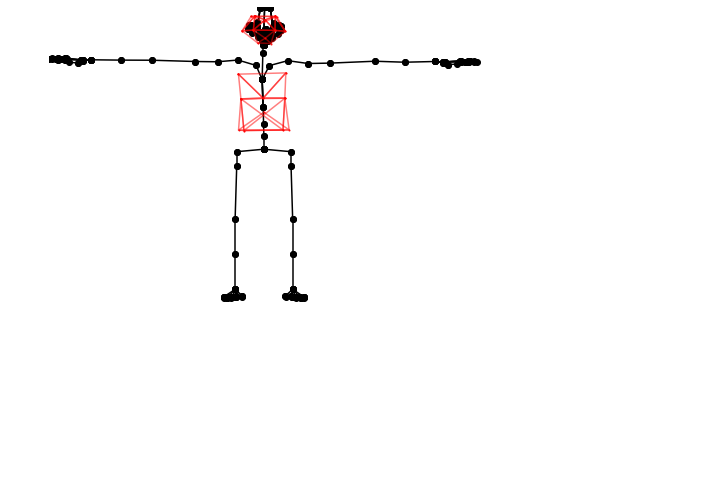

The mapping was successful


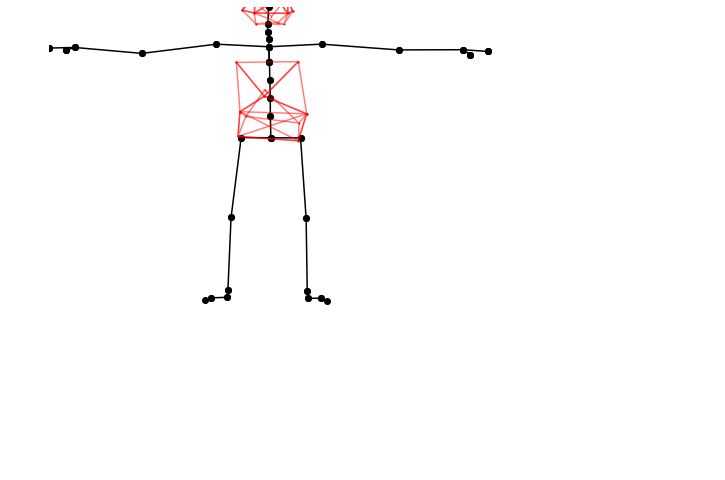

In [4]:
plotanimation.PlotPoseAndSurface(targetAnimation, targetSurface, 0, plot2d=True)
plotanimation.PlotPoseAndSurface(sourceAnimation, sourceSurface, 0, plot2d=True)

### Computing Egocentric Coordinates

## Pose Adaptation

### Inverse Kinematics

## Results

## Conclusion

## Future Works